In [11]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

import ashrae_constants as const
import prepare_data as prep

# Import the raw data

In [12]:
raw_data = prep.get_raw_data('ashrae-energy-prediction', cache_file='store_raw.h5')
prep.print_nan_counts_all_dfs(raw_data)

Importing data from store_raw.h5
NaNs for building_metadata


site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

NaNs for weather_train


site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

NaNs for weather_test


site_id                    0
timestamp                  0
air_temperature          104
cloud_coverage        140448
dew_temperature          327
precip_depth_1_hr      95588
sea_level_pressure     21265
wind_direction         12370
wind_speed               460
dtype: int64

NaNs for train


building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

NaNs for test


row_id         0
building_id    0
meter          0
timestamp      0
dtype: int64

### Check for large values

In [13]:
thresholds = [1_00_000, 1_000_000, 10_000_000]
high_meter_buildings = prep.get_buildings_with_high_meter(raw_data['train'], thresholds)

There are 10 buildings with meter readings above 0M: {1088, 993, 1159, 778, 1099, 1197, 1168, 954, 60, 1021}
There are 1 buildings with meter readings above 1M: {1099}
There are 1 buildings with meter readings above 10M: {1099}


In [14]:
high_meter_buildings

{100000: {60, 778, 954, 993, 1021, 1088, 1099, 1159, 1168, 1197},
 1000000: {1099},
 10000000: {1099}}

/anaconda3/envs/ASHRAE/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


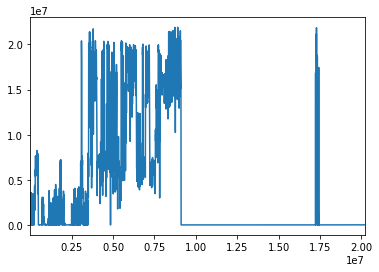

In [15]:
raw_train = raw_data['train']
for b_id in high_meter_buildings[1000000]:
    raw_data['train'][raw_train.building_id == b_id][raw_train.meter == 2].meter_reading.plot()
    plt.show()

In [16]:
#Not just one anomolous data point. Let's find out more about the building
raw_data['building_metadata'][raw_data['building_metadata'].building_id == 1099]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
1099,13,1099,Education,332884,NaN,NaN


Not just one value so not sure what to do about this - leave for now

### Strange values

In [17]:
# It is reported in this discussion by @barnwellguy that All electricity meter is 0 until May 20 for site_id == 0.
buildings_site_0 = raw_data['building_metadata'].building_id[raw_data['building_metadata'].site_id == 0]
elec_buildings_site_0 = raw_train[(raw_train.building_id.isin(list(buildings_site_0)))
                                 & (raw_train.meter == 0)]
elec_buildings_site_0.loc[:,'timestamp'] = pd.to_datetime(elec_buildings_site_0['timestamp'])
elec_buildings_site_0_pre_20may = elec_buildings_site_0[elec_buildings_site_0['timestamp'] < "2016-05-21"]

In [18]:
elec_buildings_site_0_pre_20may_pivoted = elec_buildings_site_0_pre_20may.pivot(index='timestamp',
                                     columns = 'building_id', 
                                     values = 'meter_reading')

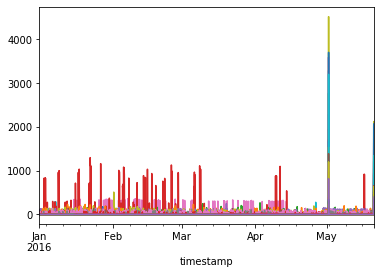

In [19]:
elec_buildings_site_0_pre_20may_pivoted.plot(legend=False)
plt.show()

There is some data there for all of the buildings but it is very odd - leave for now but bear in mind

### Are their missing timestamps?

#### Weather train

In [20]:
prep.count_missing_timestamps(raw_data['weather_train'])

There are 139773 timestamps in the data. The full date range is 8784 long and there are 16 sites so there should be 140544 timestamps in the data. There are therefore 771 missing. 


771

#### Weather test

In [21]:
prep.count_missing_timestamps(raw_data['weather_test'])

There are 277243 timestamps in the data. The full date range is 17520 long and there are 16 sites so there should be 280320 timestamps in the data. There are therefore 3077 missing. 


3077

So weather data is missing some timestamps in both test and train

### So need to...

 - fill in NAN's in weather data
 - add missing dates to weather data and interpolate the blanks
 - Not sure what to do about building 1099's steam data - doesn't seem to be just one anomoly
 - Leave the nans in the building dataframe for now - I don't think we need to use those features


## Fix them, reformat a few columns and add meter type names

In [ ]:
cleaned_data = prep.clean_data(raw_data)

Cleaning weather_train dataset
Cleaning weather_test dataset


In [ ]:
prep.print_nan_counts_all_dfs(cleaned_data)

In [ ]:
prep.count_missing_timestamps(cleaned_data['weather_train'])

In [ ]:
prep.count_missing_timestamps(cleaned_data['weather_test'])

# 1. Have a look at the data more generally
### 1.1 Building metadata

In [ ]:
cleaned_data['building_metadata']

In [ ]:
cleaned_data['building_metadata'].describe()

## 1.2 Weather training data

In [ ]:
cleaned_data['weather_train']

In [ ]:
cleaned_data['weather_train'].describe()

## 1.3 Consumption training data

In [ ]:
cleaned_data['train']

In [ ]:
cleaned_data['test']

In [ ]:
cleaned_data['train'].describe()

## 2 Combined data 

### 2.1 Stick all data together, add variables for hour of day and weekend/weekday and split on meter type

In [ ]:
joined_data = join_input_data_and_multi_index(cleaned_data, 'train')

In [ ]:
joined_data_dict = split_on_meter_type(joined_data, meter_types)